# Calibrating HBV hydrological model run locally outside container forced with ERA5 forcing data
In this notebook we will demonstrate how to calibrate the HBV model and works as an example of how to calibrate models in general.

We will use an extention to eWaterCycle: eWaterCycle-DA with DA for Data Assimilation. This package, developed by former MSc student David Haasnoot, adds functionality to deal with ensembles of models in eWaterCycle.

This assumes you have already seen [the standard notebook explaining how to run HBV on eWaterCycle.](example_model_run_HBV_camels_catchment_camels_forcing.ipynb)

Only cells which differ from that notebook are shown here, other cells are collapsed for easier viewing (but can be opened and are, of course, run!).

In [1]:
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import json

# Niceties
from rich import print
from tqdm import tqdm

In [2]:
# General eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

In [3]:
# We need the ewatercycle_DA package. If that is not available on your machine,
# uncomment the line below to install it

# !pip install ewatercycle-da

In [4]:
# eWaterCycle Data assimilation package
from ewatercycle_DA import DA

In [5]:
# Load settings
# Read from the JSON file
with open("settings.json", "r") as json_file:
    settings = json.load(json_file)

In [6]:
print(settings)

{
    'caravan_id': 'hysets_01371500',
    'calibration_start_date': '1997-08-01T00:00:00Z',
    'calibration_end_date': '2007-07-31T00:00:00Z',
    'validation_start_date': '2007-08-01T00:00:00Z',
    'validation_end_date': '2010-07-31T00:00:00Z',
    'future_start_date': '2027-08-01T00:00:00Z',
    'future_end_date': '2047-08-31T00:00:00Z',
    'CMIP_info': {
        'dataset': 'MPI-ESM1-2-HR',
        'ensembles': ['r3i1p1f1', 'r9i1p1f1'],
        'experiments': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'],
        'project': 'CMIP6',
        'frequency': 'day',
        'grid': 'gn',
        'variables': ['pr', 'tas', 'rsds']
    },
    'base_path': '/home/rhut/ewatercycleClimateImpact/HBV',
    'path_caravan': '/home/rhut/ewatercycleClimateImpact/HBV/data/hysets_01371500/caravan',
    'path_ERA5': '/home/rhut/ewatercycleClimateImpact/HBV/data/hysets_01371500/ERA5',
    'path_CMIP6': '/home/rhut/ewatercycleClimateImpact/HBV/data/hysets_01371500/CMIP6',
    'path_shape': '/home/rhut/ewatercycleClimateImpact/HBV/data/hysets_01371500/caravan/hysets_01371500.shp'
}

# Pre-generated observations of discharge from caravan
Here we re-load the disharge data we generated in [this](step_0a_select_caravan_region_time_and_scenarios.ipynb) notebook.

In [7]:
# Load the caravan forcing object
caravan_data_object = ewatercycle.forcing.sources['CaravanForcing'].load(directory=settings['path_caravan'])
print(caravan_data_object)

CaravanForcing(
    start_time='1997-08-01T00:00:00Z',
    end_time='2010-07-31T00:00:00Z',
    directory=PosixPath('/home/rhut/ewatercycleClimateImpact/HBV/data/hysets_01371500/caravan'),
    shape=PosixPath('/home/rhut/ewatercycleClimateImpact/HBV/data/hysets_01371500/caravan/hysets_01371500.shp'),
    filenames={
        'tasmax': 'hysets_01371500_1997-08-01_2010-07-31_tasmax.nc',
        'tas': 'hysets_01371500_1997-08-01_2010-07-31_tas.nc',
        'Q': 'hysets_01371500_1997-08-01_2010-07-31_Q.nc',
        'evspsblpot': 'hysets_01371500_1997-08-01_2010-07-31_evspsblpot.nc',
        'tasmin': 'hysets_01371500_1997-08-01_2010-07-31_tasmin.nc',
        'pr': 'hysets_01371500_1997-08-01_2010-07-31_pr.nc'
    }
)

## Pre-generated ERA5 forcing data for HBV model
Here we load the ERA5 data we generated in [this](step_1a_generate_historical_forcing) notebook

In [8]:
load_location = Path(settings['path_ERA5']) / "work" / "diagnostic" / "script" 
ERA5_forcing_object = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

In [9]:
print(ERA5_forcing_object)

LumpedMakkinkForcing(
    start_time='1997-08-01T00:00:00Z',
    end_time='2010-07-31T00:00:00Z',
    directory=PosixPath('/home/rhut/ewatercycleClimateImpact/HBV/data/hysets_01371500/ERA5/work/diagnostic/script')
,
    shape=PosixPath('/home/rhut/ewatercycleClimateImpact/HBV/data/hysets_01371500/ERA5/work/diagnostic/script/hyset
s_01371500.shp'),
    filenames={
        'pr': 'OBS6_ERA5_reanaly_1_day_pr_1997-2010.nc',
        'tas': 'OBS6_ERA5_reanaly_1_day_tas_1997-2010.nc',
        'rsds': 'OBS6_ERA5_reanaly_1_day_rsds_1997-2010.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

## Calibration basics and objective function
In model calibration, we are looking for a set of parameters such that when the model is run with that set of parameters, we get the best model output. What "best" means differs per application or research question. In general, we like some model outputs to be as close as possible to observations. For this purpose we create an objective function that takes the model output of interest and observations as inputs and calculates some score that shows goodness of fit. Here we use a RMS difference function:

In [10]:
def calibrationObjective(modelOutput, observation, start_calibration, end_calibration):
    '''A function that takes in two dataFrames, interpolates the model output to the
    observations and calculates the average absolute difference between the two. '''

    # Combine the two in one dataFrame
    hydro_data = pd.concat([modelOutput.reindex(observation.index, method = 'ffill'), observation], axis=1,
                           keys=['model','observation'])

    # Only select the calibration period
    hydro_data = hydro_data[hydro_data.index > pd.to_datetime(pd.Timestamp(start_calibration).date())]
    hydro_data = hydro_data[hydro_data.index < pd.to_datetime(pd.Timestamp(end_calibration).date())]

    # Calculate mean absolute difference
    squareDiff = (hydro_data['model'] - hydro_data['observation'])**2
    rootMeanSquareDiff = np.sqrt(np.mean(squareDiff))

    return rootMeanSquareDiff

## Create an ensemble of models
Instead of single model, we create an ensemble of models. In our case each ensemblemember is a HBV model that will get its own parameters. After running the entire ensemble we will apply the calibration objective function to determine the best set of parameters.

In [11]:
# Set the number of ensemble members. In Data Assimilation "ensemble member" and "particle" is used interchangeably
# Based on which school of DA you come from :-)
n_particles = 1000

In [12]:
# Create an array with parameter values.

# First set minimum and maximum values on the parameters
p_min_initial = np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001,   0.01])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01,   10.0])

# Create an empty array to store the parameter sets
parameters = np.zeros([len(p_min_initial), n_particles])

# Fill the array with random values between the minimum and maximum
for param in range(len(p_min_initial)):
    parameters[param,:] = np.random.uniform(p_min_initial[param],p_max_initial[param],n_particles)

In [13]:
# Print parameter names and values for first ensemble member
param_names = ["Imax", "Ce", "Sumax", "Beta", "Pmax", "Tlag", "Kf", "Ks", "FM"]
print(list(zip(param_names, np.round(parameters[:,0], decimals=3))))

[
    ('Imax', 5.421),
    ('Ce', 0.251),
    ('Sumax', 780.075),
    ('Beta', 3.419),
    ('Pmax', 0.221),
    ('Tlag', 4.61),
    ('Kf', 0.06),
    ('Ks', 0.006),
    ('FM', 2.396)
]

In [14]:
# Set initial state values
#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5,  0])

In [15]:
# Each ensemble member gets their own parameters
# which are set during the initialize phase.
# Here we make a list of 'arguments' to pass to the model
# during initialize.
setup_kwargs_lst = []
for index in range(n_particles):
    setup_kwargs_lst.append({'parameters': parameters[:,index],
                             })

In [16]:
# Create the ensemble object
ensemble = DA.Ensemble(N=n_particles)
ensemble.setup()

In the initialize step below we specify which model we will be using and pass the list of parameters. For other purposes (multimodel comparisons) here we could also provide lists of different models each with their own forcing and other setup arguments.

In [17]:
# This initializes the models for all ensemble members.
ensemble.initialize(model_name=["HBVLocal"]*n_particles,
                    forcing=[caravan_data_object]*n_particles,
                    setup_kwargs=setup_kwargs_lst) 

In [18]:
# We appoint one of the ensemble members the role "reference model".
# In this use case, this is pure for timekeeping as shown in the next cell
ref_model = ensemble.ensemble_list[0].model

## Models run with one command.
All models can be run with the ```ensemble.update()``` command. 

In [19]:
n_timesteps = int((ref_model.end_time - ref_model.start_time) /  ref_model.time_step)

time = []
lst_Q = [] 
for i in tqdm(range(n_timesteps)):    
    time.append(pd.Timestamp(ref_model.time_as_datetime.date()))
    ensemble.update()
    lst_Q.append(ensemble.get_value("Q").flatten())



100%|██████████| 4747/4747 [26:20<00:00,  3.00it/s]


In [20]:
ensemble.finalize()

## Find best parameter set
By calculating the objective function for each model output, we can search the combination of parameters with the lowest objective function.

In [21]:
# Create a pandas dataframe to hold all the model outputs
Q_m_arr = np.array(lst_Q).T
df_ensemble = pd.DataFrame(data=Q_m_arr[:,:len(time)].T,index=time,columns=[f'particle {n}' for n in range(n_particles)])

In [23]:
# Create a dataframe for the observations
ds_observation = xr.open_mfdataset([caravan_data_object['Q']]).to_pandas()

In [24]:
objective_values_calibration = []
for i in tqdm(range(n_particles)):
    objective_values_calibration.append(calibrationObjective(df_ensemble.iloc[:,i],ds_observation["Q"],
                                                             settings['calibration_start_date'],
                                                             settings['calibration_end_date']))

100%|██████████| 1000/1000 [00:01<00:00, 764.45it/s]


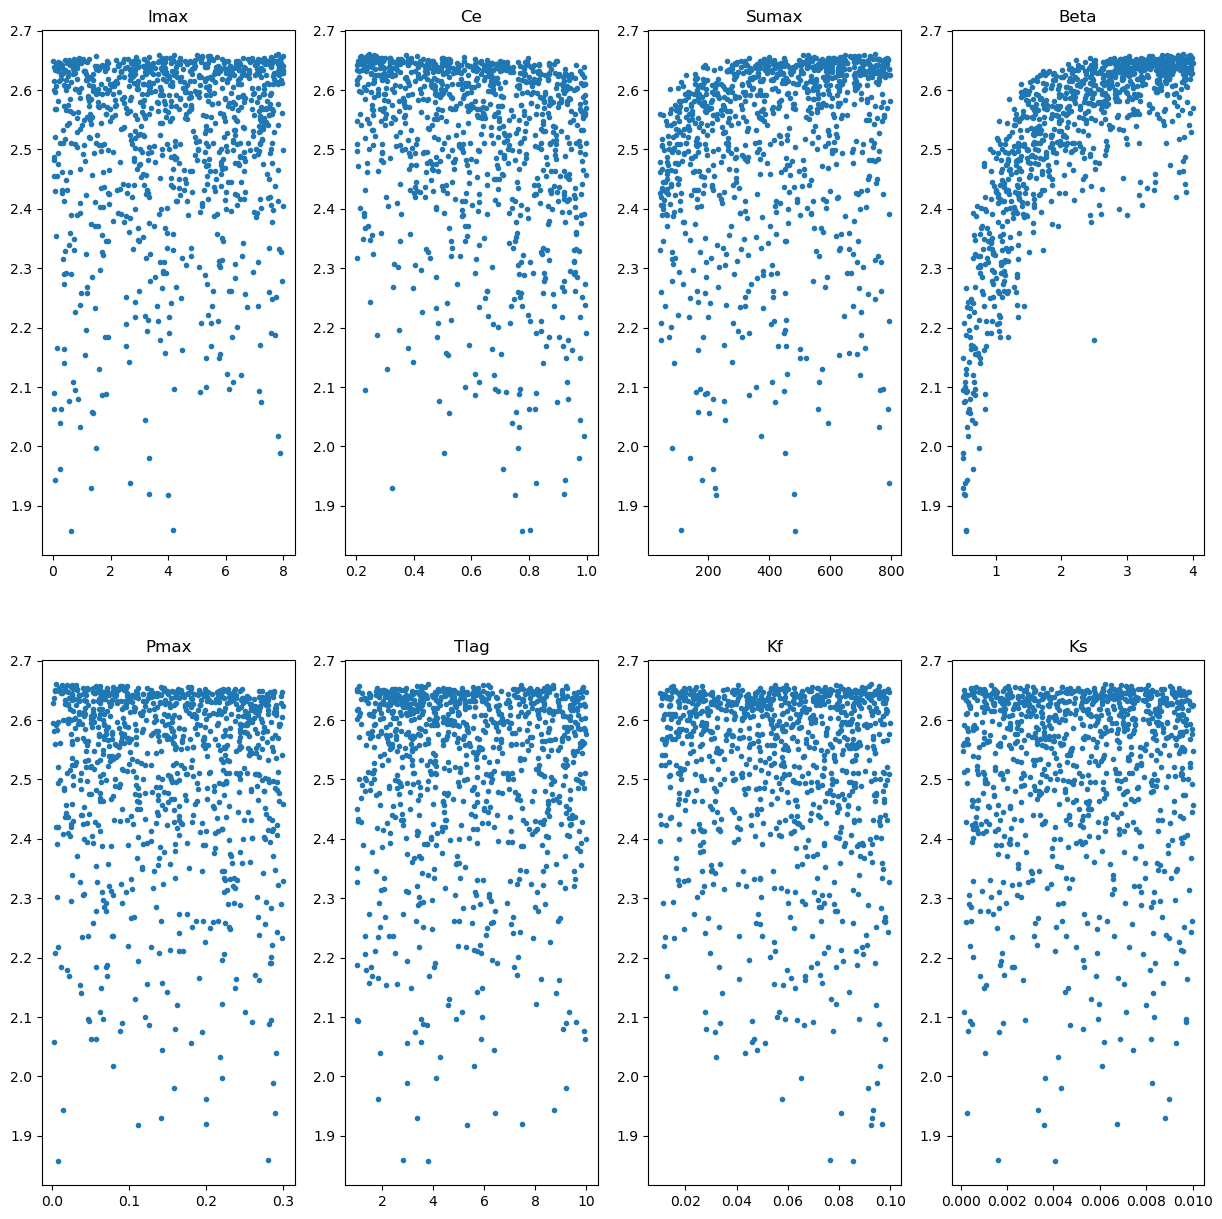

In [25]:
# Make some plot of the spread of the objective functions for the different parameters
xFigNr = 2
yFigNr = 4

fig, axs = plt.subplots(xFigNr, yFigNr,figsize = (15,15))

for xFig in range(xFigNr):
    for yFig in range(yFigNr):
        paramCounter = xFig*yFigNr + yFig
        axs[xFig,yFig].plot(parameters[paramCounter,:],objective_values_calibration,'.')
        axs[xFig,yFig].set_title(param_names[paramCounter])

In [26]:
# Let's also print the minimal values:
parameters_minimum_index = np.argmin(np.array(objective_values_calibration))

parameters_minimum = parameters[:,parameters_minimum_index]

print(list(zip(param_names, np.round(parameters_minimum, decimals=3))))

[
    ('Imax', 0.636),
    ('Ce', 0.777),
    ('Sumax', 483.732),
    ('Beta', 0.551),
    ('Pmax', 0.007),
    ('Tlag', 3.788),
    ('Kf', 0.085),
    ('Ks', 0.004),
    ('FM', 7.153)
]

<Axes: xlabel='time'>

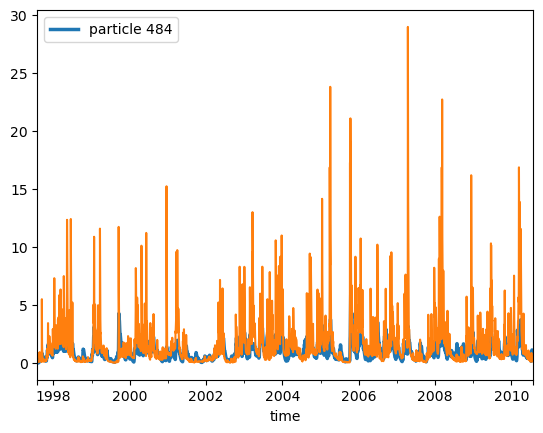

In [27]:
# Make a plot of the model output of the minimum value
ax = df_ensemble.iloc[:,parameters_minimum_index].plot(lw=2.5)
plt.legend()
ds_observation["Q"].plot()

In [28]:
df_best = df_ensemble.iloc[:,parameters_minimum_index]

In [29]:
df_best.index = df_best.index.tz_localize("UTC")
df_select = df_best.tz_convert("UTC")[settings['validation_start_date']:settings['validation_end_date']]

(13726.0, 14821.0)

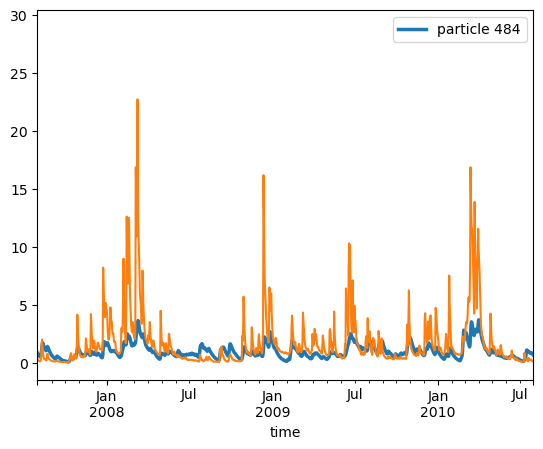

In [30]:
# Make a plot of the model output of the minimum value
ax = df_select.plot(lw=2.5)
plt.legend()
ds_observation["Q"].plot()
plt.xlim(settings['validation_start_date'],settings['validation_end_date'])

## Save results
We want to save these results to file to be able to load them in other studies

In [31]:
# Save to csv file
np.savetxt(settings['path_caravan'] + "/" + settings['caravan_id'] + ".csv", parameters_minimum, delimiter=",")